In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
#constants
SEQUENCE_LEN = 100

TODO:

- die dictionaries sollen funktional, unabhaängig vond er klasse sein, also werden die songs als solche ebreits auserhalb genereirt, dann einfach songs drausen generieren, dict anlegen, dann klasse schreiben die songs bekommt

- https://github.com/LeanManager/NLP-PyTorch/blob/master/Character-Level%20LSTM%20with%20PyTorch.ipynb
- https://www.analyticsvidhya.com/blog/2020/08/build-a-natural-language-generation-nlg-system-using-pytorch/

# Load and prepare Data

Lets begin by importing the data.

In [3]:
file = 'eurobeat_lyrics.csv'

songs  = np.array(open(file,'r').read().split(';'))
songs = songs[:-1]

In [4]:
#function to call in dataset class
def getSongs(filepath):
    songs  = np.array(open(file,'r').read().split(';'))
    return songs[:-1]

The songs have different lengths. We want to split the songs in sequences of characters, all the same length. We also want the sequences to overlap.

In [5]:
#get a whole song and return an array (n, seq_len) of n seqeunces of length seq_len, which are the characters of the song
#each sequence has teh same length
def song2sequences(song, seq_len):
    song_len = len(song)
    n_seq = 2*(song_len//seq_len)
    seq = np.empty((n_seq, seq_len), dtype=str)
    
    song = np.array([ch for ch in song])
    for i in range(n_seq-1):
        seq[i] = song[int(i*(seq_len/2)) : int(seq_len + i*seq_len/2)]
    seq[n_seq-1] = song[-(seq_len):]
    
    return seq

#lets create all the sequences for all our songs and concatenate them in one array
#so proud i wrote this line myself
def songs2sequences(songs, seq_len=SEQUENCE_LEN):
    return np.concatenate(([song2sequences(song, seq_len) for song in songs]))

In [6]:
def songs2contSequences(allsongs, seq_len):
    #1. turn all songs into 1 string
    together = '\n\n'.join(allsongs)
    chars = [char for char in together]
    n_seq = len(together)//seq_len

    sequences = []
    for i in range(n_seq):
        sequences.append(chars[i*seq_len:(i+1)*seq_len])

    return np.array(sequences)

In [7]:
#sequences = songs2sequences(songs,SEQUENCE_LEN)

## Tokenization

Create a dictionary to link letters to numbers.

A `set` removes all dublicate elements. We want a dictionary we can use for all songs therefore we must create a set from all songs.

In [8]:
#set of all chars
chars = set(' '.join(songs))

In [9]:
#dictionaries, linking a integer to a symbol
int2char_dict = dict(enumerate(chars))
char2int_dict = { int2char_dict[k]:k for k in int2char_dict}
#print(int2char_dict[6])
#print(char2int_dict['E'])

Now turn the sequences into integers. We then want to use `OneHot` of pytorch to encode the sequences as Propability Mass Vectors.

The resulting tensor `sequences_OH` does now have the shape (seq_n, seq_len, len(chars)) as each character is represented by a len(chars)-long base vector.

In [10]:
#turn the sequences into integers by dictionary
#sequences_int = torch.tensor([[char2int_dict[char] for char in seq] for seq in sequences])
#print(sequences_int.dtype)

#one-hot encoding
#sequences_OH = F.one_hot(sequences_int)
#print(sequences_OH[0,0])
#print(sequences_int[0,0])
#print(sequences[0,0])

In [11]:
#sequences_int[0]
#print(''.join([int2char[ch] for ch in sequences_int[0]]))

def OneHotSequence2String(seq):
    seq = seq.numpy()
    seq = np.argmax(seq, axis=1)
    return ''.join([int2char_dict[ch] for ch in seq])

Now define a custom Dataset-Class and DataLoader.

In [12]:
class LyricsDataset(Dataset):
    def __init__(self, songs, seq_len, dict_len, int2char, char2int): #constructor
        
        self.seq_len = seq_len
        self.dict_len = dict_len
        self.int2char = int2char
        self.char2int = char2int
        
        
        self.songs = songs
        self.sequences_raw = songs2contSequences(self.songs, self.seq_len)
        #turn the sequences into integers by dictionary
        self.sequences_int = torch.tensor([[self.char2int[char] for char in seq] for seq in self.sequences_raw])
        #one-hot encoding
        self.sequences = F.one_hot(self.sequences_int).to(float)
        
        #target: forward(sequences[i]) predicts sequences_target[i]=sequences[i+1]
        #take the raw sequence and advance one element
        self.sequences_target_raw = np.roll(self.sequences_raw,-1)
        self.sequencess_target_int = torch.tensor([[self.char2int[char] for char in seq] for seq in self.sequences_target_raw])
        self.sequences_target = F.one_hot(self.sequencess_target_int).to(float)


    def __len__(self): 
        return self.sequences.shape[0] #return the number of sequences
    
    def __getitem__(self, idx): 
        return self.sequences[idx], self.sequences_target[idx] #return the sequences and targets

In [13]:
dataset = LyricsDataset(songs,SEQUENCE_LEN, len(chars), int2char_dict, char2int_dict)
dataloader = DataLoader(dataset, batch_size=5)

In [14]:
for seq, tar in dataloader:
    print(tar.shape)
    print(OneHotSequence2String(seq[0]))
    print('----------')
    print(OneHotSequence2String(tar[0]))
    break

torch.Size([5, 100, 77])
Lost in my reaction

Dancing like a Parapara star in Japan

My name is like a thunder

Baby, you can
----------
ost in my reaction

Dancing like a Parapara star in Japan

My name is like a thunder

Baby, you can 


# Define a model

In [88]:
class LSTMNetwork(torch.nn.Module):
    #seq_length: length of seqeunce: 100
    # char_dim: length of hot ones base vectors/length of dictionary
    #hidden layer dim
    def __init__(self, sequence_dim, char_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()
        self.sequence_dim = sequence_dim
        self.char_dim = char_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout_prob = dropout_prob

        #lstm
        self.lstm = torch.nn.LSTM(input_size=self.char_dim, hidden_size=self.hidden_dim,
                                 num_layers=self.n_layers, batch_first=True,
                                 dropout=self.dropout_prob)
        

        # The linear layer that maps from hidden state space to char-propability space
        self.lin = torch.nn.Linear(self.hidden_dim, self.char_dim)
        
        #init the hidden layer, weights and bias of lstm and lin

    def forward(self, x_n, hc_prev):
        #print(f'{self.lstm}')
        y_n, hc = self.lstm(x_n, hc_prev)
        
        #stack up the 2 lstm cells, send output of fisrt into second
        y_n = y_n.contiguous().view(y_n.size()[0]*y_n.size()[1], self.hidden_dim)
        
        ## Put y_n through the output
        y_n = self.lin(y_n)
        
        return y_n, hc
    
    def forwardTEST(self, x_n, hc_prev):
        #print(f'{self.lstm}')
        y_n, hc = self.lstm(x_n, hc_prev)
        
        #print(y_n.size())
        y_test = y_n
        #stack up the 2 lstm cells, send output of fisrt into second 
        y_n = y_n.contiguous().view(y_n.size()[0]*y_n.size()[1], self.hidden_dim)
        
        ## Put y_n through the output
        y_n = self.lin(y_n)
        
        return y_test, y_n, hc
    
    
    #this is called after training to generate a new character based on the on before
    #incase this isn't the first char to be generated: pay attention to the hidden state,
    #carrying the information of prev states
    def predict(self, char, h, char2int, int2char):
        #convert and reshape
        char_int = char2int[char]
        char_int = torch.reshape(torch.tensor(char_int), (1,-1))
        char_oh = F.one_hot(char_int, num_classes=self.char_dim).to(float)
        #init hidden layers
        if (h is None):
            h = self.init_hidden(1)
        h = tuple([hc.data for hc in h])
        
        #get the output from the model
        prediction, h = net.forward(char_oh, h)
        
        #----------------------------------
        #apply softmax to get a normed propability distribution
        softm = torch.nn.Softmax(dim=1)
        prediction = softm(prediction) #torch.squeeze(prediction)
        
        prediction_oh = prediction
        
        #----------------------------------

        #convert into numpy array
        prediction_oh = prediction_oh.detach().numpy()
        
        #get the corresponding character
        
        prediction_selection = np.argsort(prediction_oh)[-1:]
        prediction_selection = prediction_selection.squeeze()
        prediction_int = np.random.choice(prediction_selection)

        prediction_char = int2char[prediction_int]
        
        return prediction_char, h
        
    
    def init_hidden(self, batch_size):
        # Create two new tensors with sizes (n_layers, n_seqs, hidden_dim)
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        

In [16]:
#---------testing

#prep data
dataset = LyricsDataset(songs, seq_len=SEQUENCE_LEN, dict_len=len(chars), int2char=int2char_dict, char2int=char2int_dict)
data = DataLoader(dataset, batch_size=5, drop_last=True)

net_test2 = LSTMNetwork(sequence_dim=dataset.seq_len, char_dim=dataset.dict_len, hidden_dim=128, n_layers=2, dropout_prob=0.5)

In [17]:
x = next(iter(data))[0] #x
net_test2 = net_test2.double()
h = net_test2.init_hidden(5)
y_test, out , (h,_) = net_test2.forwardTEST(x, h)

ytt = y_test.contiguous().view(y_test.size()[0]*y_test.size()[1], net_test2.hidden_dim)

# Training process

1. Beginn by defining:
- `opt` The optimization algorithm (Gradient decent).
- `loss_function` Evaluate the accuracy of the current state with the Cross Entropy Function.
2. Next, set the model into training mode, this is only relevant for the Dropout Layer.
3. We will loop over the whole data several times with the `epochs` loop.
4. For every epoch the hidden layer needs to be reset.
5. Now we loop over the batches of our dataset. We have a `target` batch with which we will later compare the processed `input`.
6. Reset the Gradient and reintroduce the hidden state, this prevents the backwards propagation from going beyond the current state.
7. Now finally, calculate the predictions `output`. This also returns the hidden state `h`.
8. Perform the backwards propagation:
- Calculate the loss.
- Call `backward()`.
- `clip_grad_norm_` prevents the parameters from exploding.
- update the parameters.
9. print the training status.

In [22]:
def training(net, data, sequence_dim, dict_len, batch_size,  epochs=10, lr=0.01):
    
    net = net.double()
    
    # optimizer
    opt = torch.optim.SGD(net.parameters(), lr=lr)
    # loss
    loss_function = torch.nn.CrossEntropyLoss()

    #need to set the mode
    net.train()
        
    losses = []
    
    for e in range(epochs):
        lo = 0
        counter = 0

        #initialize hidden state
        h = net.init_hidden(batch_size)
        
        for inputs, targets in data:
            counter+= 1
            
            #reset the gradients
            net.zero_grad()
            #reentroduce the hidden state
            h = tuple([hc.data for hc in h])
            #get the output from the model
            outputs, h = net.forward(inputs, h)
            
            #calculate the loss and perform backprop
            loss = loss_function(outputs, targets.contiguous().view(batch_size*sequence_dim,-1))
            lo += loss
            #back-propagate error
            loss.backward()
            #helps prevent the exploding gradient problem in RNNs / LSTMs.
            torch.nn.utils.clip_grad_norm_(net.parameters(), 5)
            # update weigths
            opt.step()
            
            
            if counter % 50 == 0:
                print("Epoch: {}/{}...".format(e+1, epochs),
                    "Step: {}...".format(counter))
        losses.append(lo)
    return losses

In [23]:
#prep data
batch_size = 20
dataset = LyricsDataset(songs, seq_len=SEQUENCE_LEN, dict_len=len(chars), int2char=int2char_dict, char2int=char2int_dict)
data = DataLoader(dataset, batch_size=batch_size, drop_last=True)

In [24]:
# Initialize and print the network
net = LSTMNetwork(sequence_dim=dataset.seq_len, char_dim=dataset.dict_len, hidden_dim=128, n_layers=2, dropout_prob=0.5)

#training
loss = training(net, data, sequence_dim=dataset.seq_len, dict_len=dataset.dict_len, batch_size=batch_size, epochs=10, lr=0.1)

Epoch: 1/10... Step: 50...
Epoch: 1/10... Step: 100...
Epoch: 1/10... Step: 150...
Epoch: 1/10... Step: 200...
Epoch: 1/10... Step: 250...
Epoch: 1/10... Step: 300...
Epoch: 2/10... Step: 50...
Epoch: 2/10... Step: 100...
Epoch: 2/10... Step: 150...
Epoch: 2/10... Step: 200...
Epoch: 2/10... Step: 250...
Epoch: 2/10... Step: 300...
Epoch: 3/10... Step: 50...
Epoch: 3/10... Step: 100...
Epoch: 3/10... Step: 150...
Epoch: 3/10... Step: 200...
Epoch: 3/10... Step: 250...
Epoch: 3/10... Step: 300...
Epoch: 4/10... Step: 50...
Epoch: 4/10... Step: 100...
Epoch: 4/10... Step: 150...
Epoch: 4/10... Step: 200...
Epoch: 4/10... Step: 250...
Epoch: 4/10... Step: 300...
Epoch: 5/10... Step: 50...
Epoch: 5/10... Step: 100...
Epoch: 5/10... Step: 150...
Epoch: 5/10... Step: 200...
Epoch: 5/10... Step: 250...
Epoch: 5/10... Step: 300...
Epoch: 6/10... Step: 50...
Epoch: 6/10... Step: 100...
Epoch: 6/10... Step: 150...
Epoch: 6/10... Step: 200...
Epoch: 6/10... Step: 250...
Epoch: 6/10... Step: 300..

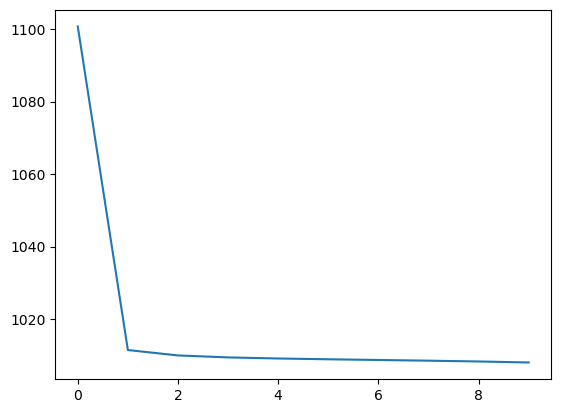

In [25]:
plt.plot(np.array([el.detach().numpy() for el in loss]))

In [89]:
net2 = LSTMNetwork(sequence_dim=dataset.seq_len, char_dim=dataset.dict_len, hidden_dim=128, n_layers=2, dropout_prob=0.5)
net2.lstm = net.lstm
net2.lin = net.lin

In [95]:
let = 'K'
h_m = None

sent = [let]
for k in range(50):
    let, h_m = net2.predict(let, h_m, char2int_dict, int2char_dict)
    sent.append(let)
    
print(''.join(sent))
    

KS3L!G:5EF"re(jLcfTN83bV2iJB
moY)GaggGQ31bb2n(tW(


In [93]:
sent

['K',
 'd',
 'p',
 "'",
 'w',
 'K',
 '7',
 'K',
 'N',
 'd',
 'X',
 'r',
 't',
 'o',
 '(',
 'U',
 '-',
 'A',
 'm',
 'k',
 'w']